# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [2]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [3]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
        self._in_features = in_features
        self._out_features = out_features
        self._W = np.random.rand(in_features, out_features)
        self._b = np.random.rand(out_features)
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        self._x = x
        y = x @ self._W + self._b
        return y
    
    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self._dW = self._x.T @ d
        self._db = d.reshape(-1, self._out_features).sum(axis=0)
        return d @ self._W.T

    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        self._W -= alpha * self._dW
        self._b -= alpha * self._db

In [4]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self._x = x
        y = np.maximum(0, x)
        return y
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        _d = (self._x >= 0) * d
        return _d
        
class Softmax(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """
    def __init__(self):
        pass
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Softmax(x) (стабильная версия). 
        Возвращает корректный результат, если все входные значения имеют большой порядок.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self._x = x
        shift = x - np.max(x, axis=len(x.shape)-1, keepdims=True)
        exps = np.exp(shift)
        y = exps / np.sum(exps, axis=len(x.shape)-1, keepdims=True)
        return y

        
    def backward(self, pred: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки, 
        учитывая CE в качестве функции ошибки.

        Parameters
        ----------
        pred : np.ndarray
            Вероятности.

        y : np.ndarray
            Вектор правильных классов.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        T = np.zeros(pred.shape)
        T[np.arange(pred.shape[0]), y] = 1 
        return (pred - T)

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [5]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обученияю
        alpha : float
            Cкорость обучения.
        """
        self._modules = modules.copy()
        self._modules.append(Softmax())
        self._epochs = epochs
        self._alpha = alpha
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """

        for epoch in range(self._epochs):
            order = np.random.permutation(len(X))
            
            for start_index in range(0, len(X), batch_size):
                batch_indexes = order[start_index:(start_index + batch_size)]
                
                X_batch = X[batch_indexes]
                y_batch = y[batch_indexes]

                pred = self.predict_proba(X_batch)
                sm = self._modules[-1]
                d = sm.backward(pred, y_batch)

                for module in reversed(self._modules[:-1]):
                    d = module.backward(d)
                    module.update(self._alpha)
        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        pred = X

        for module in self._modules:
            pred = module.forward(pred)

        return pred
        
    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [6]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = np.array([(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X])
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [7]:
%%time
np.random.seed(0)
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)
best_acc, worst_acc = 0, 1
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 4), 
        ReLU(), 
        Linear(4, 4),
        ReLU(),
        Linear(4, 2)])

    p.fit(X, y)
    mean_acc = np.mean(p.predict(X_test) == y_test)
    best_acc = max(mean_acc, best_acc)
    worst_acc = min(mean_acc, worst_acc)
print("Accuracy", best_acc)
print("Worst accuracy", worst_acc)

Accuracy 1.0
Worst accuracy 0.8725
CPU times: user 1.33 s, sys: 804 µs, total: 1.33 s
Wall time: 1.34 s


In [8]:
%%time
np.random.seed(0)
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc, worst_acc = 0, 1
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 3)])

    p.fit(X, y)
    mean_acc = np.mean(p.predict(X_test) == y_test)
    best_acc = max(mean_acc, best_acc)
    worst_acc = min(mean_acc, worst_acc)
print("Accuracy", best_acc)
print("Worst accuracy", worst_acc)

Accuracy 0.9475
Worst accuracy 0.945
CPU times: user 652 ms, sys: 0 ns, total: 652 ms
Wall time: 657 ms


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [10]:
print(f'Is cuda available: {torch.cuda.is_available()}')

Is cuda available: True


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2) # 3 x 32 x 32 ---> 16 x 32 x 32
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 16 x 32 x 32 ---> 16 x 16 x 16

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=5, padding=2) # 16 x 16 x 16 ---> 20 x 16 x 16
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 20 x 16 x 16 ---> 20 x 8 x 8

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5, padding=2) # 20 x 8 x 8 ---> 20 x 8 x 8
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 20 x 8 x 8 ---> 20 x 4 x 4

        self.fc1 = nn.Linear(20 * 4 * 4, 120)
        self.act4 = nn.ReLU()

        self.fc2 = nn.Linear(120, 84)
        self.act5 = nn.ReLU()

        self.fc3 = nn.Linear(84, 10)
        self.act6 = nn.Softmax()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.fc3(x)
        x = self.act6(x)

        return x
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    N = len(X)
    pred = model.forward(X)
    CE = -torch.sum((torch.log(pred[np.arange(N), y]))) / N
    return CE

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [13]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [14]:
%%time
model = Model().to(device)
train_l, test_l = train(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 | Train loss 2.1433326528167727 | Test loss 2.0002363872528077
Epoch 1 | Train loss 1.944528342475891 | Test loss 1.8299477737426757
Epoch 2 | Train loss 1.789583053779602 | Test loss 1.7550458715438844
Epoch 3 | Train loss 1.7161148612976074 | Test loss 1.6548862880706787
Epoch 4 | Train loss 1.6513910135269165 | Test loss 1.6101477666854858
Epoch 5 | Train loss 1.602454947090149 | Test loss 1.5675082401275635
Epoch 6 | Train loss 1.567196669998169 | Test loss 1.5273263872146607
Epoch 7 | Train loss 1.5279706916046143 | Test loss 1.5022759048461913
Epoch 8 | Train loss 1.486991219482422 | Test loss 1.50316405544281
Epoch 9 | Train loss 1.462068252105713 | Test loss 1.4533114330291748
Epoch 10 | Train loss 1.4273173779678345 | Test loss 1.4150530408859252
Epoch 11 | Train loss 1.4081505514907837 | Test loss 1.3773654350280762
Epoch 12 | Train loss 1.3814138073348998 | Test loss 1.3874122564315796
Epoch 13 | Train loss 1.357576201019287 | Test loss 1.339943318939209
Epoch 14 | T

Построим график функции потерь

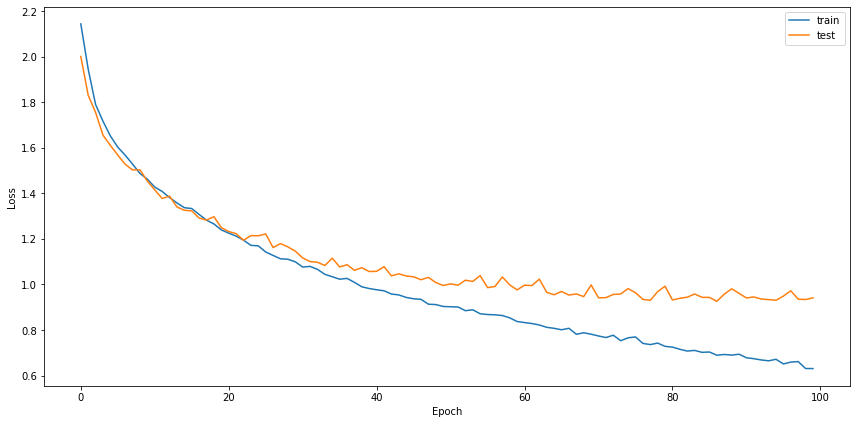

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [17]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Overall accuracy 0.6878
Precision [0.71455939 0.82531381 0.56231884 0.46636364 0.65084388 0.5565371
 0.77582645 0.76033058 0.84865471 0.79101358]
Recall [0.746 0.789 0.582 0.513 0.617 0.63  0.751 0.736 0.757 0.757]
Mean Precision 0.6951761973208546
Mean Recall 0.6878
